# 🛍️ E-commerce User Behavior Analysis and Purchase Prediction Report 

## 📘 Project Overview
This project is based on the Alibaba Tianchi e-commerce user behavior dataset. Through data cleaning, behavior analysis, user profiling construction, and machine learning modeling, etc., it deeply explores the user conversion paths and purchase intentions, assisting e-commerce platforms in achieving precise marketing and user stratified operation. 

---


## 🌟 Key Features of the Project 

🎯 Key Highlights of the Content:
- Comprehensive analysis of user behaviors: click → collection → add to cart → purchase
- Construction of user profiles and implementation of user clustering (KMeans)
- Establishment of a purchase prediction model (LightGBM) to enhance the intelligence of operational strategies
- Interpretability analysis (SHAP) to help understand the key features underlying the predictions 

### 🧠 Key Technical Features:
- Big Data Processing: Reading and merging nearly 76 million pieces of behavioral data in blocks
- Model Prediction: Building a classification model using LightGBM, integrating standardization and stratified sampling
- Visualization: Presenting in full detail the user behavior periods, conversion rate distribution, and model interpretation results 

---

# Part 1: Feature Engineering

In [1]:
import pandas as pd
import zipfile
import os

zip_path = "Alibaba.zip"
csv_filename = "UserBehavior.csv"
chunk_size = 1_000_000
output_dir = "processed_chunks"
os.makedirs(output_dir, exist_ok=True)

column_names = ['user_id', 'product_id', 'product_category', 'behavior_type', 'timestamp']
behavior_map = {
    'pv': 'click',
    'buy': 'purchase',
    'cart': 'add_to_cart',
    'fav': 'favorite'
}

def process_chunk(chunk, i):
   
    chunk['behavior_type'] = chunk['behavior_type'].map(behavior_map)

    # Time
    chunk['datetime'] = pd.to_datetime(chunk['timestamp'], unit='s')
    chunk['hour'] = chunk['datetime'].dt.hour
    chunk['weekday'] = chunk['datetime'].dt.weekday
    chunk['day'] = chunk['datetime'].dt.day
    chunk['date_str'] = chunk['datetime'].dt.strftime('%Y-%m-%d')

    # User
    user_behavior = chunk.groupby(['user_id', 'behavior_type']).size().unstack(fill_value=0).reset_index()
    user_behavior.rename(columns={
        'click': 'user_click_count',
        'favorite': 'user_fav_count',
        'add_to_cart': 'user_cart_count',
        'purchase': 'user_purchase_count'
    }, inplace=True)

    # Product
    item_behavior = chunk.groupby(['product_id', 'behavior_type']).size().unstack(fill_value=0).reset_index()
    item_behavior.rename(columns={
        'click': 'item_click_count',
        'favorite': 'item_fav_count',
        'add_to_cart': 'item_cart_count',
        'purchase': 'item_purchase_count'
    }, inplace=True)
    item_behavior['item_conversion_rate'] = item_behavior['item_purchase_count'] / (item_behavior['item_click_count'] + 1e-5)

    # User x Product
    interaction = chunk.groupby(['user_id', 'product_id', 'behavior_type']).size().unstack(fill_value=0).reset_index()
    interaction.rename(columns={
        'click': 'ui_clicks',
        'favorite': 'ui_favs',
        'add_to_cart': 'ui_carts',
        'purchase': 'ui_purchases'
    }, inplace=True)

    merged = interaction.merge(user_behavior, on='user_id', how='left')
    merged = merged.merge(item_behavior, on='product_id', how='left')

    # Purchase
    merged['label'] = (merged['ui_purchases'] > 0).astype(int)

    merged['hour'] = chunk.groupby(['user_id', 'product_id'])['hour'].first().values
    merged['weekday'] = chunk.groupby(['user_id', 'product_id'])['weekday'].first().values
    merged['date_str'] = chunk.groupby(['user_id', 'product_id'])['date_str'].first().values

    selected_cols = [
        'user_id', 'product_id',
        'ui_clicks', 'ui_carts', 'ui_favs', 'ui_purchases',
        'user_click_count', 'user_cart_count', 'user_purchase_count',
        'item_click_count', 'item_cart_count', 'item_purchase_count',
        'item_conversion_rate',
        'hour', 'weekday', 'date_str',
        'label'
    ]

    merged = merged[selected_cols]

    output_path = os.path.join(output_dir, f"chunk_{i}.parquet")
    merged.to_parquet(output_path, index=False)

with zipfile.ZipFile(zip_path) as z:
    with z.open(csv_filename) as f:
        reader = pd.read_csv(f, names=column_names, chunksize=chunk_size)
        for i, chunk in enumerate(reader):
            process_chunk(chunk, i)

In [2]:
import glob
import pandas as pd

all_chunks = glob.glob("processed_chunks/chunk_*.parquet")
df_list = []
for path in all_chunks:
    df_list.append(pd.read_parquet(path))

df_full = pd.concat(df_list, ignore_index=True)
df_full

,user_id,product_id,ui_clicks,ui_carts,ui_favs,ui_purchases,user_click_count,user_cart_count,user_purchase_count,item_click_count,item_cart_count,item_purchase_count,item_conversion_rate,hour,weekday,date_str,label
0,1,46259,2,0,0,0,55,0,0,2,0,0,0.000000,18,1,2017-11-28,0
1,1,79715,1,0,0,0,55,0,0,1,0,0,0.000000,17,3,2017-11-30,0
2,1,230380,1,0,0,0,55,0,0,22,2,0,0.000000,21,5,2017-11-25,0
3,1,266784,2,0,0,0,55,0,0,4,0,0,0.000000,15,1,2017-11-28,0
4,1,271696,1,0,0,0,55,0,0,20,0,0,0.000000,3,6,2017-12-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75970035,992842,4876800,1,0,0,0,105,2,1,54,6,1,0.018519,15,1,2017-11-28,0
75970036,992842,5001661,1,0,0,0,105,2,1,8,0,0,0.000000,15,5,2017-11-25,0
75970037,992842,5034795,1,0,0,0,105,2,1,1,0,0,0.000000,14,5,2017-11-25,0
75970038,992842,5072273,1,0,0,0,105,2,1,1,0,0,0.000000,6,1,2017-11-28,0


# Part 2: User Research

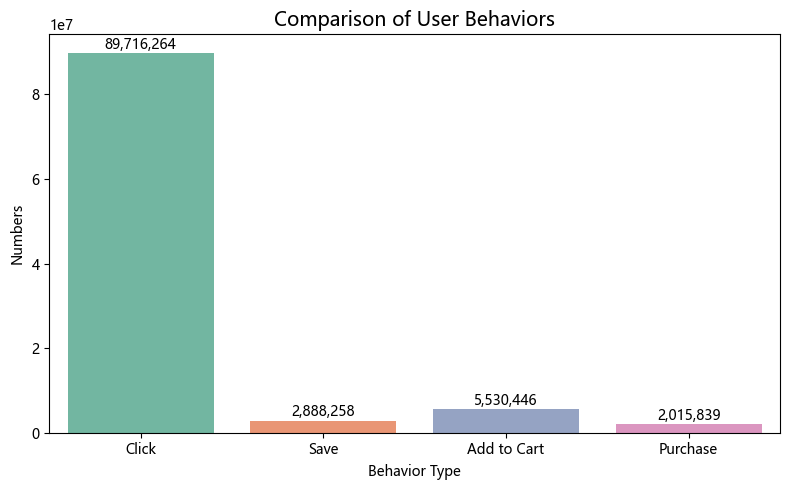

In [3]:
# User Behavior Histogram
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_path = "C:/Windows/Fonts/msyh.ttc"
font_prop = FontProperties(fname=font_path)

matplotlib.rcParams['font.family'] = font_prop.get_name()
matplotlib.rcParams['axes.unicode_minus'] = False

behavior_totals = {
    'Click': df_full['ui_clicks'].sum(),
    'Save': df_full['ui_favs'].sum(),
    'Add to Cart': df_full['ui_carts'].sum(),
    'Purchase': df_full['ui_purchases'].sum()
}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(behavior_totals.keys()), y=list(behavior_totals.values()), palette="Set2")
plt.title("Comparison of User Behaviors", fontsize=14)
plt.ylabel("Numbers")
plt.xlabel("Behavior Type")
for index, value in enumerate(behavior_totals.values()):
    plt.text(index, value + 1e6, f'{int(value):,}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

### 📊 Comparison of Total User Behavior Volume 

> 💡 **Insights：**
> - Click actions are far more frequent, reaching approximately 90 million times, accounting for over 80% of the total.
> - Purchase actions only account for about 2.2%, indicating a significant bottleneck in conversion.
> - Collection and add-to-cart actions are regarded as intermediate behaviors, accounting for approximately 3% and 6% respectively.
> - The platform is confronted with the problem of abundant traffic but low conversion rate. Subsequently, it is necessary to focus on analyzing the conversion paths and the driving factors of behaviors.

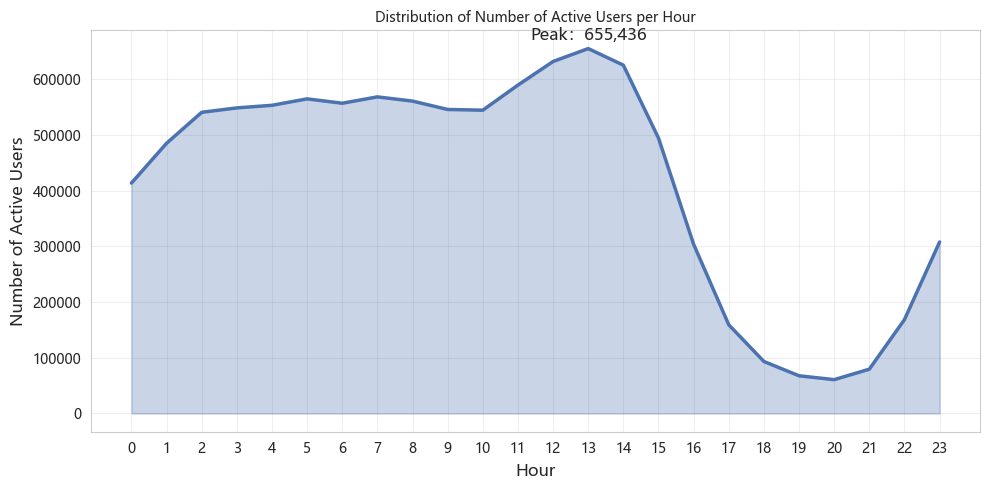

In [4]:
# Number of Active Users per Hour
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")
active_users = df_full.groupby('hour')['user_id'].nunique()
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
sns.lineplot(x=active_users.index, y=active_users.values, linewidth=2.5, color="#4C72B0")
plt.fill_between(active_users.index, active_users.values, alpha=0.3, color="#4C72B0")

peak_hour = active_users.idxmax()
peak_value = active_users.max()
plt.text(peak_hour, peak_value + 15000, f"Peak：{peak_value:,}", ha='center', fontsize=12, fontproperties=font_prop)

plt.title("Distribution of Number of Active Users per Hour", fontsize=16, fontproperties=font_prop)
plt.xlabel("Hour", fontsize=12, fontproperties=font_prop)
plt.ylabel("Number of Active Users", fontsize=12, fontproperties=font_prop)
plt.xticks(range(0, 24), fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 📊 User Activity Periods Analysis

> 💡 **Insights:**
> - The peak of activity is concentrated around noon from 12 to 14 o'clock, with the maximum peak reaching 650,000 users.
> - The activity level significantly drops after 8 p.m.
> - Noon is the prime time for users to browse, making it suitable for promoting discounts or curated content; although the activity level is low in the early morning, the conversion rate is high (see the subsequent conversion rate chart), and it is worth testing the night-time promotion strategy.

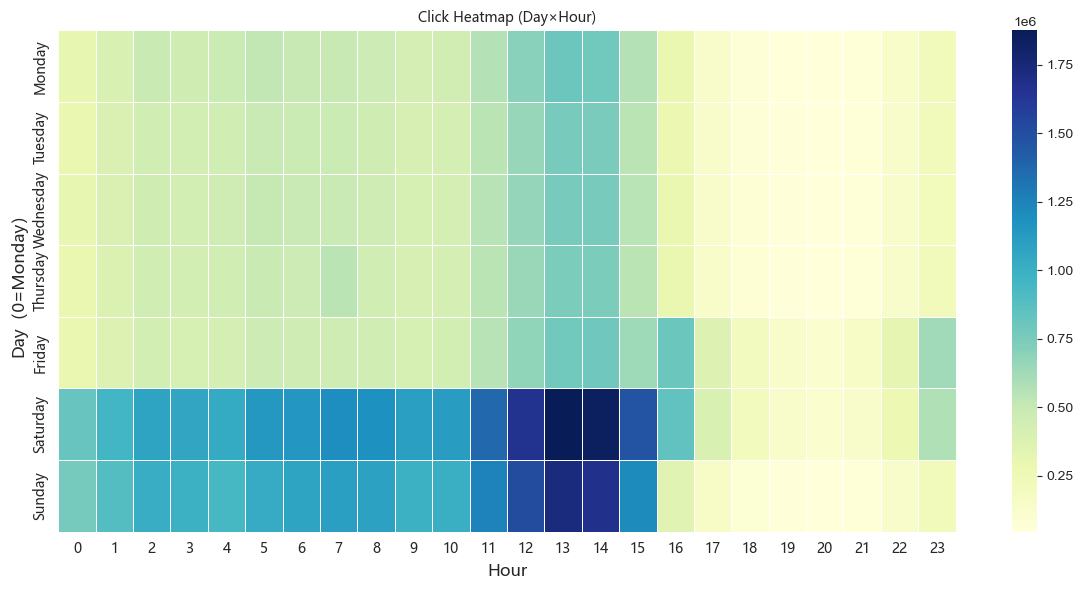

In [15]:
# Click Heatmap (Day×Hour)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

click_heatmap = df_full.pivot_table(
    index='weekday', columns='hour', values='ui_clicks', aggfunc='sum', fill_value=0
)

plt.figure(figsize=(12, 6))
click_heatmap.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.heatmap(click_heatmap, cmap="YlGnBu", linewidths=0.5, annot=False)

plt.title("Click Heatmap (Day×Hour)", fontsize=16, fontproperties=font_prop)
plt.xlabel("Hour", fontsize=12, fontproperties=font_prop)
plt.ylabel("Day（0=Monday）", fontsize=12, fontproperties=font_prop)
plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

plt.tight_layout()
plt.show()

### 📊 Click Heatmap (Week × Hour) 

> 💡 **Insights:**
> - The click volume surges significantly on weekends (especially on Saturdays), particularly during the noon period.
> - The concentrated clicks during weekdays occur in the midday and afternoon.
> - The strategy for increasing the exposure of products on weekends should be strengthened, especially for the promotion and placement during the noon period. Alternatively, a precise operation based on festival marketing could be adopted.

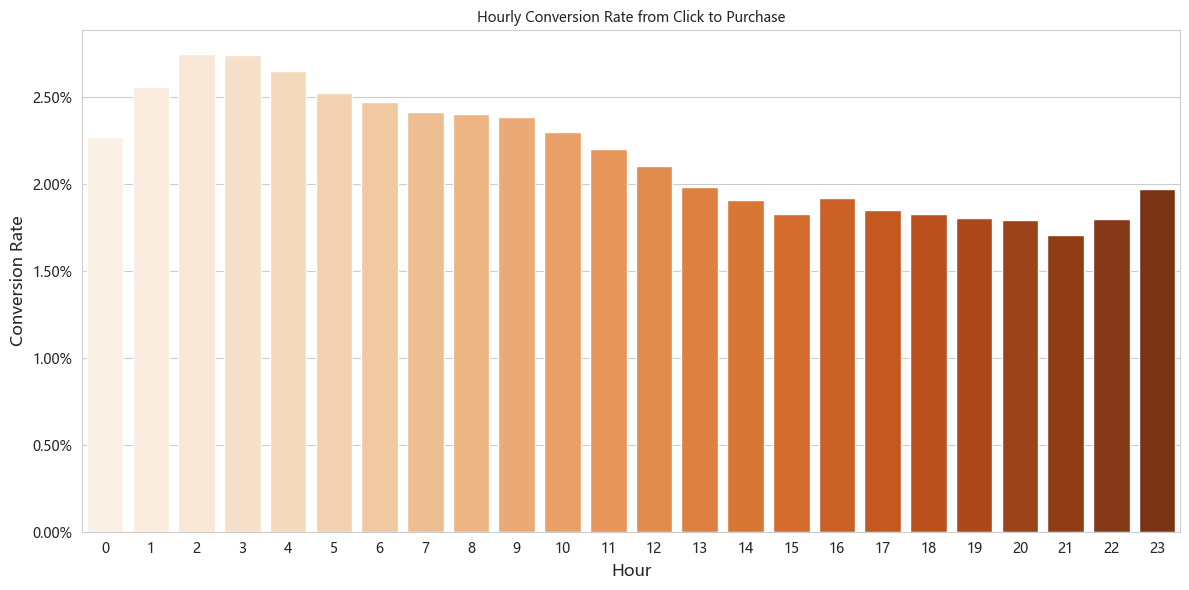

In [6]:
# Hourly Conversion Rate from Click to Purchase
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.font_manager import FontProperties
import seaborn as sns
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

hourly = df_full.groupby('hour')[['ui_clicks', 'ui_purchases']].sum()
hourly['Conversion Rate'] = hourly['ui_purchases'] / (hourly['ui_clicks'] + 1e-5)

plt.figure(figsize=(12, 6))
sns.barplot(x=hourly.index, y=hourly['Conversion Rate'], palette='Oranges')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("Hourly Conversion Rate from Click to Purchase", fontsize=16, fontproperties=font_prop)
plt.xlabel("Hour", fontsize=12, fontproperties=font_prop)
plt.ylabel("Conversion Rate", fontsize=12, fontproperties=font_prop)
plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)
plt.tight_layout()
plt.show()

### 📊 Hourly Click-through Rate Analysis 

> 💡 **Insights:**
> - The conversion rate is the highest between 3 a.m. and 5 a.m. (over 2.7%)
> - The traffic volume is high during the day but the conversion efficiency decreases instead
> - This indicates that users who browse at night have stronger purchase intentions, making it suitable to promote time-limited sales promotions and midnight flash sales activities.

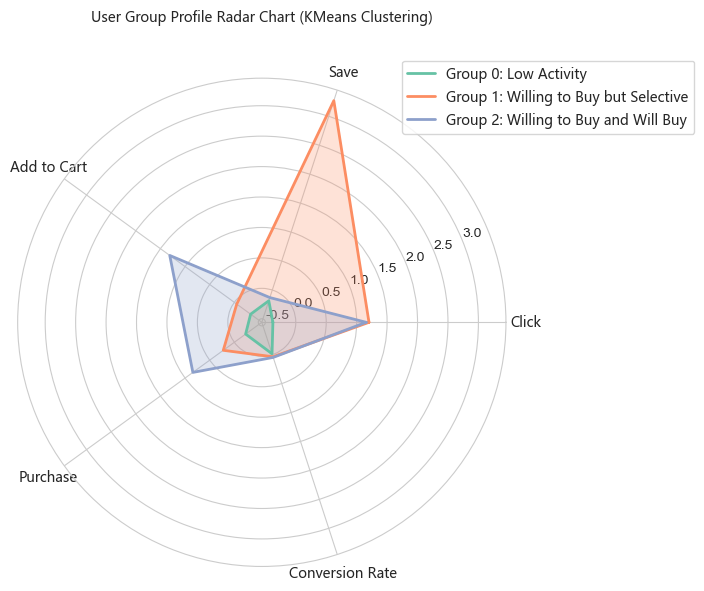

In [14]:
# User Profile Radar Chart (KMeans)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

# Clustering
user_features = df_full.groupby('user_id')[['ui_clicks', 'ui_favs', 'ui_carts', 'ui_purchases']].sum()
user_features['conversion_rate'] = user_features['ui_purchases'] / (user_features['ui_clicks'] + 1e-5)
feature_cols = ['ui_clicks', 'ui_favs', 'ui_carts', 'ui_purchases', 'conversion_rate']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_features[feature_cols])
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
user_features['cluster'] = kmeans.fit_predict(X_scaled)
centroids = kmeans.cluster_centers_

labels = ['Click', 'Save', 'Add to Cart', 'Purchase', 'Conversion Rate']
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]
colors = ['#66C2A5', '#FC8D62', '#8DA0CB']

group_labels = [
    "Group 0: Low Activity",
    "Group 1: Willing to Buy but Selective",
    "Group 2: Willing to Buy and Will Buy"
]

plt.figure(figsize=(7, 6))
for i, color in enumerate(colors):
    values = centroids[i]
    values = np.concatenate((values, [values[0]])) 
    plt.polar(angles, values, label=group_labels[i], color=color, linewidth=2)
    plt.fill(angles, values, color=color, alpha=0.25)

plt.xticks(angles[:-1], labels, fontsize=11, fontproperties=font_prop)
plt.title("User Group Profile Radar Chart (KMeans Clustering)", fontsize=16, fontproperties=font_prop, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.05), fontsize=11, prop=font_prop)
plt.tight_layout()
plt.show()

### 📊 User Profile Clustering Analysis (KMeans)

> 💡 **Insights:**
> - The user base can be categorized into three main types: cold users who merely browse without any subsequent actions; collectors who prefer to purchase but hesitate; and high-conversion users who are active and prone to making purchases.
> - Differentiated operations can be carried out based on the characteristics of these groups. For instance, coupons can be sent to collectors to encourage them to make purchases, and new products can be pre-promoted to high-conversion users to increase their interest in them.

# Part 3: Funnel Analysis

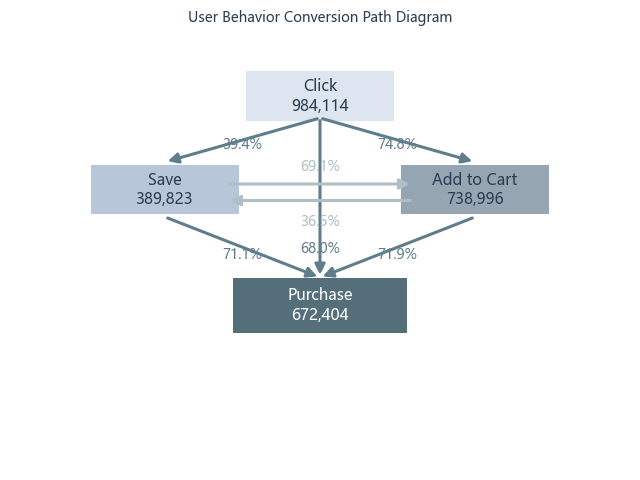

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Rectangle
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

click_users = set(df_full[df_full['ui_clicks'] > 0]['user_id'])
fav_users = set(df_full[df_full['ui_favs'] > 0]['user_id'])
cart_users = set(df_full[df_full['ui_carts'] > 0]['user_id'])
buy_users = set(df_full[df_full['ui_purchases'] > 0]['user_id'])

click_to_buy = len(click_users & buy_users)
fav_to_buy = len(fav_users & buy_users)
cart_to_buy = len(cart_users & buy_users)

rate_click_buy = click_to_buy / len(click_users) * 100
rate_fav_buy = fav_to_buy / len(fav_users) * 100
rate_cart_buy = cart_to_buy / len(cart_users) * 100

rate_click_to_fav = len(click_users & fav_users) / len(click_users) * 100
rate_click_to_cart = len(click_users & cart_users) / len(click_users) * 100
rate_fav_to_cart = len(fav_users & cart_users) / len(fav_users) * 100
rate_cart_to_fav = len(cart_users & fav_users) / len(cart_users) * 100

colors = {
    'Click': '#DDE6F0',
    'Save': '#B8C6D9',
    'Add to Cart': '#95A5B2',
    'Purchase': '#546E7A',
    'Background': '#FFFFFF',
    'Text': '#2C3E50',
    'Arrow': '#607D8B',
    'Arrow with a light color': '#B0BEC5'
}

fig, ax = plt.subplots(figsize=(8, 5.5))  
ax.set_xlim(0, 10)
ax.set_ylim(0, 8)
ax.set_facecolor(colors['Background'])
ax.axis('off')

def draw_box(x, y, w, h, title, val, color, text_color='#2C3E50'):
    rect = Rectangle((x - w/2, y - h/2), w, h, facecolor=color, edgecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, f"{title}\n{val:,}", ha='center', va='center',
            fontsize=11, fontproperties=font_prop, color=text_color)

def draw_arrow(p1, p2, text=None, color=colors['Arrow'], text_position='above', text_offset_y=None):
    ax.add_patch(FancyArrowPatch(p1, p2, arrowstyle='-|>', color=color, lw=2.2, mutation_scale=15))
    if text is not None:
        mx, my = (p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2
        if text_offset_y is not None:
            dy = text_offset_y
        else:
            dy = 0.25 if text_position == 'above' else -0.45
        ax.text(mx, my + dy, f"{text:.1f}%", ha='center', fontsize=10, fontproperties=font_prop, color=color)

draw_box(5, 6.8, 2.4, 0.9, "Click", len(click_users), colors['Click'])
draw_box(2.5, 5.1, 2.4, 0.9, "Save", len(fav_users), colors['Save'])
draw_box(7.5, 5.1, 2.4, 0.9, "Add to Cart", len(cart_users), colors['Add to Cart'])
draw_box(5, 3.0, 2.8, 1.0, "Purchase", len(buy_users), colors['Purchase'], 'white')

# Click → Save / Add to Cart
draw_arrow((5, 6.4), (2.5, 5.6), rate_click_to_fav, text_offset_y=-0.15)
draw_arrow((5, 6.4), (7.5, 5.6), rate_click_to_cart, text_offset_y=-0.15)
# Click / Save / Add to Cart → Purchase
draw_arrow((2.5, 4.6), (5, 3.5), rate_fav_buy, text_offset_y=-0.2)
draw_arrow((7.5, 4.6), (5, 3.5), rate_cart_buy, text_offset_y=-0.2)
draw_arrow((5, 6.4), (5, 3.5), rate_click_buy, text_offset_y=-1.0)
# Save ↔ Add to Cart
draw_arrow((3.5, 5.2), (6.5, 5.2), rate_fav_to_cart, color=colors['Arrow with a light color'], text_position='above')
draw_arrow((6.5, 4.9), (3.5, 4.9), rate_cart_to_fav, color=colors['Arrow with a light color'], text_position='below')

plt.title("User Behavior Conversion Path Diagram", fontsize=15, fontproperties=font_prop, color=colors['Text'])
plt.subplots_adjust(top=0.88, bottom=0.08)
plt.show()

### 📊 User Conversion Path Analysis Chart (Funnel Chart) 

> 💡 **Insights:**
> - The conversion rate from click to add to cart is as high as 75%.
> - There is a significant mutual conversion relationship between "favourite" and "add to cart".
> - The conversion rate from "favourite" to "purchase" is relatively low (71%).
> - The path from "favourite" to "add to cart" to "purchase" should be optimized. For instance, dynamic reminders for favourite items in the shopping cart can be implemented to increase the final purchase rate.

# Part 4: Purchase Forecast

In [9]:
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

feature_cols = [
    'ui_clicks', 'ui_carts', 'ui_favs',
    'user_click_count', 'user_cart_count', 'user_purchase_count',
    'item_click_count', 'item_cart_count', 'item_purchase_count',
    'item_conversion_rate', 'hour', 'weekday'
]

# Data Sampling
df_sampled = df_full.sample(n=50000, random_state=42)

X = df_sampled[feature_cols]
y = df_sampled['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# LightGBM 
lgbm = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 996, number of negative: 39004
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.024900 -> initscore=-3.667672
[LightGBM] [Info] Start training from score -3.667672


LGBMClassifier(random_state=42)

In [10]:
# Model Evaluation
y_probs = lgbm.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

print("Accuracy Rate：", accuracy_score(y_test, y_pred))
print("Precision Rate：", precision_score(y_test, y_pred))
print("Recall Rate：", recall_score(y_test, y_pred))
print("F1 Score ：", f1_score(y_test, y_pred))
print("AUC：", roc_auc_score(y_test, y_probs))

Accuracy Rate： 0.9896
Precision Rate： 0.8222222222222222
Recall Rate： 0.7429718875502008
F1 Score ： 0.7805907172995781
AUC： 0.9959394546702861


### 📈  Model Evaluation

| Indicator     | Value       |
|----------------|-----------------|
| Accuracy Rate  | 0.9896       |
| Precision Rate | 0.8222       |
| Recall Rate   | 0.7430       |
| F1 Score     | 0.7806       |
| AUC Value     | 0.9959       | 

- The overall accuracy rate of the model in judging whether to purchase is very high. However, considering the imbalance of categories in the sample (most are not purchased), the accuracy rate cannot fully reflect the quality of the model.
- Among the users judged by the model as "likely to purchase", 82% are actually going to purchase. This indicates that the model's recommendation quality is high and it is suitable for resource-sensitive recommendations (such as coupon distribution).
- It can identify 74% of actual purchasing users, indicating that the model's coverage of "potential purchasers" is acceptable, but there is still room for further optimization.
- Based on the precision and recall rates, it shows that the model has achieved a good balance between precise identification and comprehensive coverage.
- An AUC close to 1 indicates that the model is almost perfect in distinguishing positive and negative samples and has very strong - classification ability. It is a powerful candidate for enterprise deployment.

The model not only has a high accuracy rate, but also takes into account both precision and recall capabilities when identifying purchasing users. It can be used as the core component of a recommendation system.

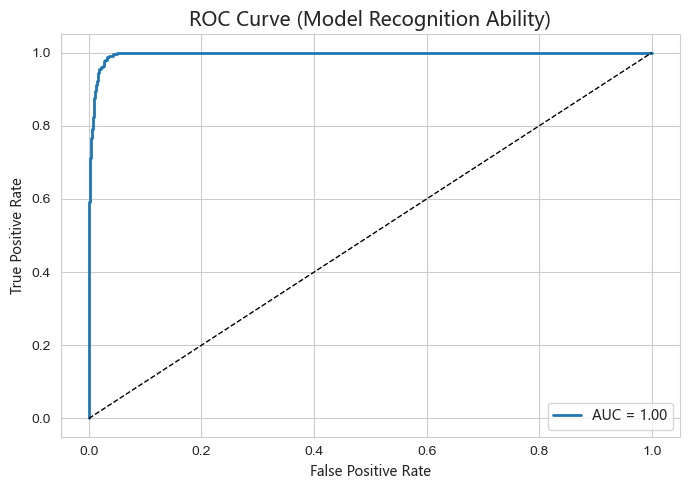

In [11]:
# ROC Curve
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.metrics import roc_curve, roc_auc_score
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

fpr, tpr, _ = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlabel("False Positive Rate", fontproperties=font_prop)
plt.ylabel("True Positive Rate", fontproperties=font_prop)
plt.title("ROC Curve (Model Recognition Ability)", fontproperties=font_prop, fontsize=14)
plt.legend(prop=font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()

### 📊 Evaluation of LightGBM Prediction Performance 

> 💡 **Insights:**
> - The AUC is approximately 1.00, indicating that the model has an extremely strong recognition ability.
> - The performance shows a slight tendency towards "overfitting", and considering the application of time sliding windows or data deduplication might be beneficial.
> - This model can be utilized for predicting users with high intent, assisting in precise marketing, recommendation, and repeat purchase strategies.

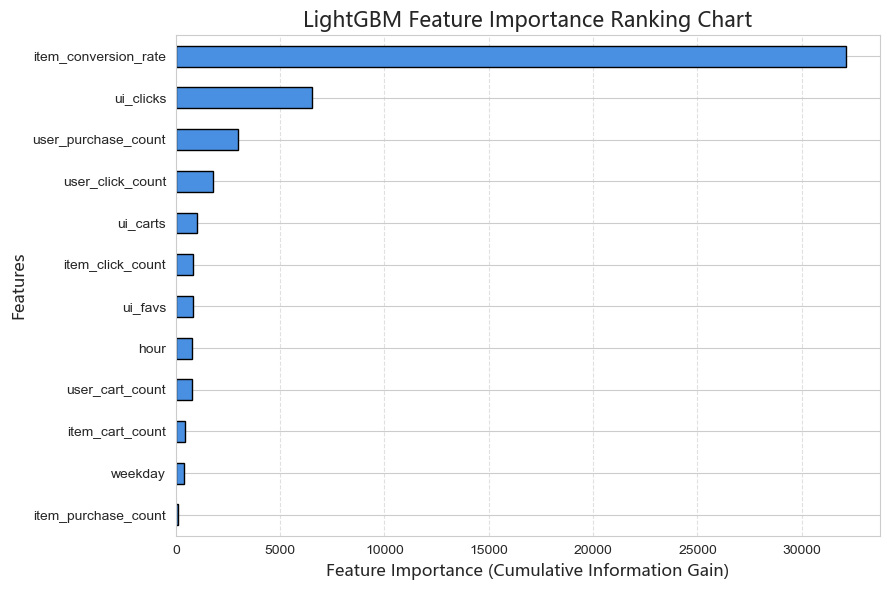

In [12]:
# Feature Importance
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

feat_imp = pd.Series(
    lgbm.booster_.feature_importance(importance_type='gain'),
    index=feature_cols
).sort_values()

plt.figure(figsize=(9, 6))
feat_imp.plot(
    kind='barh',
    color='#4A90E2',
    edgecolor='black'
)
plt.title("LightGBM Feature Importance Ranking Chart", fontproperties=font_prop, fontsize=15)
plt.xlabel("Feature Importance (Cumulative Information Gain)", fontproperties=font_prop, fontsize=12)
plt.ylabel("Features", fontproperties=font_prop, fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 📊 Feature Importance Analysis 

💡 **Insights:**
> - `item_conversion_rate` is the most significant influencing factor.
> - `user_purchase_count`, which represents the historical purchase behavior of users, ranks high.
> - This indicates that the conversion performance of the product itself and the historical activity level of users are the core indicators for predicting purchases.

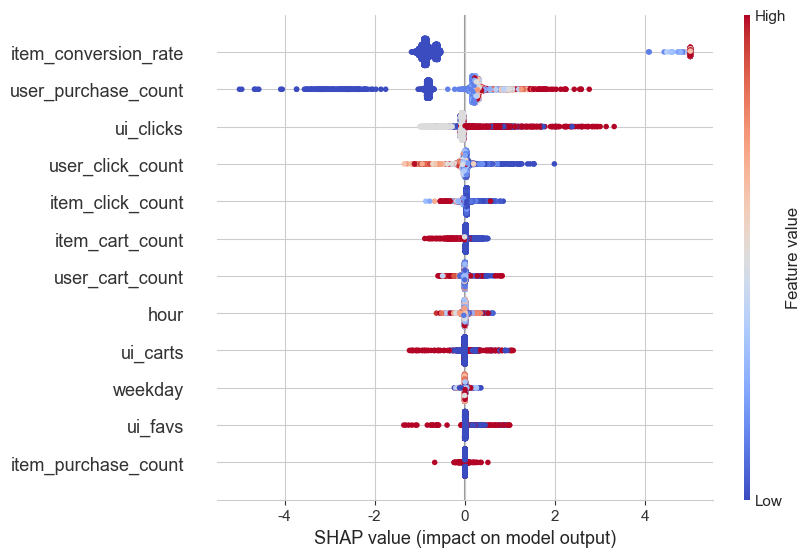

In [13]:
# Beewarm
import shap
import numpy as np
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

explainer = shap.Explainer(lgbm)
shap_values = explainer(X_test)
shap_values.feature_names = feature_cols
shap_values.values = np.clip(shap_values.values, -5, 5)

shap.plots.beeswarm(
    shap_values,
    max_display=12,
    color=plt.cm.coolwarm,  
    show=True  #
)

### 📊 Interpretability Analysis 

> 💡 **Insights:**
> - The SHAP analysis indicates that `item_conversion_rate` and `user_purchase_count` have the greatest impact on the predicted values.
> - Time-related factors such as `hour` and `weekday` have a relatively minor influence but their directions are clear.
> - By integrating SHAP, we can identify which features actually "increase" the probability of user purchases, which is beneficial for strategy formulation and deployment.

# Part 5: Business Suggestion

Based on the results of this analysis and modeling, for the aspects of user operation and product recommendation in e-commerce platforms, the following actionable strategy suggestions are provided: 

### For Users with High Purchase Intention
- **Early Exposure and Personalized Recommendations:** The model can effectively identify such users. It is necessary to prioritize the promotion of hot-selling products, new product launches, etc.
- **Precise Coupon Distribution:** This can help save budget while enhancing conversion rate. 

### For users who have collected items but haven't made a purchase yet
- **Initiate collection reminder / price drop notification**
- **Offer "re-purchase incentives":** such as lower threshold for full discounts, additional gift offers, etc. 

### Optimization of Product Dimension
- `item_conversion_rate` is the primary factor influencing purchases. The platform should:
- Enhance the quality of descriptions, images, and comments for low-conversion products
- Increase the ranking weight or prioritize the promotion of high-conversion products 

### Suggested Timing for Precision Marketing
- Peak Activity Period: Noon 12-14 PM, and weekends (especially Saturdays) are the core marketing periods.
- High Conversion Period: Users have a stronger willingness to convert during the early morning hours from 2 to 5 AM. Consider integrating "Nighttime Exclusive Discounts" promotions. 

---

Through the entire process of behavior analysis + clustering and grouping + predictive modeling + interpretable output, this project has already demonstrated certain capabilities for productization. It can be applied to:
- Optimization of advertising placement
- Fine-tuned population operation
- Enhancement of user tags in recommendation systems
- Improvement of marketing activity conversion rates